In [1]:
# Cell 1: Setup and Imports

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import nibabel as nib
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Check how many GPUs are available
print("GPUs available:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")

# Set default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

GPUs available: 2
   GPU 0: Tesla T4
   GPU 1: Tesla T4
Using device: cuda


In [2]:
import tarfile
from tqdm import tqdm

tar_path = "/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar"
extract_path = "/kaggle/working/"

# Open the tar file
with tarfile.open(tar_path, "r") as tar:
    members = tar.getmembers()
    # tqdm wraps the iteration so you see a progress bar
    for member in tqdm(members, desc="Extracting BraTS2021"):
        tar.extract(member, path=extract_path)

Extracting BraTS2021: 100%|██████████| 7508/7508 [03:10<00:00, 39.51it/s]


In [3]:
# Cell 2: Define Data Paths

# After extraction, the folder will exist in /kaggle/working/
base_path = '/kaggle/working/'

# Get a list of all patient directories
patient_dirs = glob.glob(os.path.join(base_path, "BraTS2021_*"))

# Count total files (all .nii.gz inside all patient folders)
all_files = glob.glob(os.path.join(base_path, "BraTS2021_*", "*.nii.gz"))

# Print summary
print(f"Found {len(patient_dirs)} patient directories.")
print(f"Total number of NIfTI files: {len(all_files)}")

if len(patient_dirs) > 0:
    print(f"Example patient folder: {patient_dirs[0]}")
    print("Example files inside it:")
    sample_files = glob.glob(os.path.join(patient_dirs[0], "*.nii.gz"))
    for f in sample_files:
        print("   ", os.path.basename(f))
else:
    print("Error: Could not find patient directories. Check the 'base_path'.")


Found 1251 patient directories.
Total number of NIfTI files: 6255
Example patient folder: /kaggle/working/BraTS2021_01476
Example files inside it:
    BraTS2021_01476_seg.nii.gz
    BraTS2021_01476_flair.nii.gz
    BraTS2021_01476_t1ce.nii.gz
    BraTS2021_01476_t2.nii.gz
    BraTS2021_01476_t1.nii.gz


In [4]:
## Cell 3: 3D U-Net Model Implementation

# Helper module for the U-Net
class DoubleConv3D(nn.Module):
    """(Convolution -> BatchNorm -> ReLU) * 2 for 3D data"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

# Main 3D U-Net architecture
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_classes):
        super(UNet3D, self).__init__()
        self.inc = DoubleConv3D(in_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool3d(2), DoubleConv3D(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool3d(2), DoubleConv3D(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool3d(2), DoubleConv3D(256, 512))
        self.bottleneck = nn.Sequential(nn.MaxPool3d(2), DoubleConv3D(512, 1024))
        self.up1 = nn.ConvTranspose3d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv3D(1024, 512)
        self.up2 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv3D(512, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv3D(256, 128)
        self.up4 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv3D(128, 64)
        self.out_conv = nn.Conv3d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2)
        x4 = self.down3(x3); x5 = self.bottleneck(x4)
        x = self.up1(x5); x = torch.cat([x, x4], dim=1); x = self.conv1(x)
        x = self.up2(x); x = torch.cat([x, x3], dim=1); x = self.conv2(x)
        x = self.up3(x); x = torch.cat([x, x2], dim=1); x = self.conv3(x)
        x = self.up4(x); x = torch.cat([x, x1], dim=1); x = self.conv4(x)
        return self.out_conv(x)

print("3D U-Net model defined successfully.")

3D U-Net model defined successfully.


In [5]:
## Cell 4: Baseline Loss Function

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = nn.functional.softmax(y_pred, dim=1)
        # Ensure y_true is in the correct shape and type
        y_true_c = y_true.clone().squeeze(1)
        # Remap label 4 to 3 for one-hot encoding
        y_true_c[y_true_c == 4] = 3
        y_true_one_hot = nn.functional.one_hot(y_true_c.to(torch.int64), num_classes=4).permute(0, 4, 1, 2, 3)
        
        # Flatten tensors for calculation
        y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], -1)
        y_true_one_hot = y_true_one_hot.view(y_true_one_hot.shape[0], y_true_one_hot.shape[1], -1)
        
        intersection = torch.sum(y_pred * y_true_one_hot, dim=2)
        union = torch.sum(y_pred, dim=2) + torch.sum(y_true_one_hot, dim=2)
        
        dice_coeff = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # We want to minimize the loss, so we return 1 - dice_coeff
        return 1 - torch.mean(dice_coeff)

print("DiceLoss defined successfully.")

DiceLoss defined successfully.


In [6]:
#BraTSDataset - Images as float tensors (normalized) and labels as integer masks (class indices).
class BraTSDataset(Dataset):
    def __init__(self, file_list, patch_size=(128, 128, 128), num_samples_per_volume=8, augment=False):
        self.file_list = file_list
        self.patch_size = patch_size
        self.num_samples_per_volume = num_samples_per_volume
        self.augment = augment

    def __len__(self):
        return len(self.file_list) * self.num_samples_per_volume

    def __getitem__(self, idx):
        # --- Select patient ---
        patient_idx = idx // self.num_samples_per_volume
        patient_dir = self.file_list[patient_idx]
        patient_id = os.path.basename(patient_dir)
        
        # --- Load modalities ---
        modalities = ['flair', 't1', 't1ce', 't2']
        images = []
        for mod in modalities:
            file_path = os.path.join(patient_dir, f"{patient_id}_{mod}.nii.gz")
            img = nib.load(file_path).get_fdata(dtype=np.float32)  # keep as float
            images.append(img)
        
        # --- Load segmentation label ---
        label_path = os.path.join(patient_dir, f"{patient_id}_seg.nii.gz")
        label = nib.load(label_path).get_fdata(dtype=np.float32)  # must load as float
        label = label.astype(np.uint8)  # convert safely to int classes
        
        # --- Stack modalities into 4-channel tensor ---
        image = np.stack(images, axis=0)

        # --- Normalize each channel ---
        for c in range(image.shape[0]):
            mask = image[c] > 0
            if np.any(mask):
                mean = np.mean(image[c][mask])
                std = np.std(image[c][mask])
                if std > 0:
                    image[c] = (image[c] - mean) / std

        # --- Random patch sampling ---
        img_shape = image.shape[1:]
        crop_size = self.patch_size
        for _ in range(10):  # try up to 10 times to capture tumor
            z_start = np.random.randint(0, img_shape[2] - crop_size[2] + 1)
            y_start = np.random.randint(0, img_shape[1] - crop_size[1] + 1)
            x_start = np.random.randint(0, img_shape[0] - crop_size[0] + 1)
            
            cropped_label = label[
                x_start:x_start+crop_size[0],
                y_start:y_start+crop_size[1],
                z_start:z_start+crop_size[2]
            ]
            if np.any(cropped_label > 0):
                break
        
        cropped_image = image[
            :,
            x_start:x_start+crop_size[0],
            y_start:y_start+crop_size[1],
            z_start:z_start+crop_size[2]
        ]

        # --- Augmentation ---
        if self.augment:
            if np.random.rand() > 0.5:
                cropped_image = np.flip(cropped_image, axis=1).copy()
                cropped_label = np.flip(cropped_label, axis=0).copy()
            if np.random.rand() > 0.5:
                cropped_image = np.flip(cropped_image, axis=2).copy()
                cropped_label = np.flip(cropped_label, axis=1).copy()
        
        # --- Convert to torch tensors ---
        cropped_image = torch.from_numpy(cropped_image).float()   # (4, D, H, W)
        cropped_label = torch.from_numpy(cropped_label[np.newaxis, ...]).long()  # (1, D, H, W)

        return cropped_image, cropped_label


Random patient directory: /kaggle/working/BraTS2021_00283
Processed image shape: torch.Size([4, 128, 128, 128])
Processed label shape: torch.Size([1, 128, 128, 128])


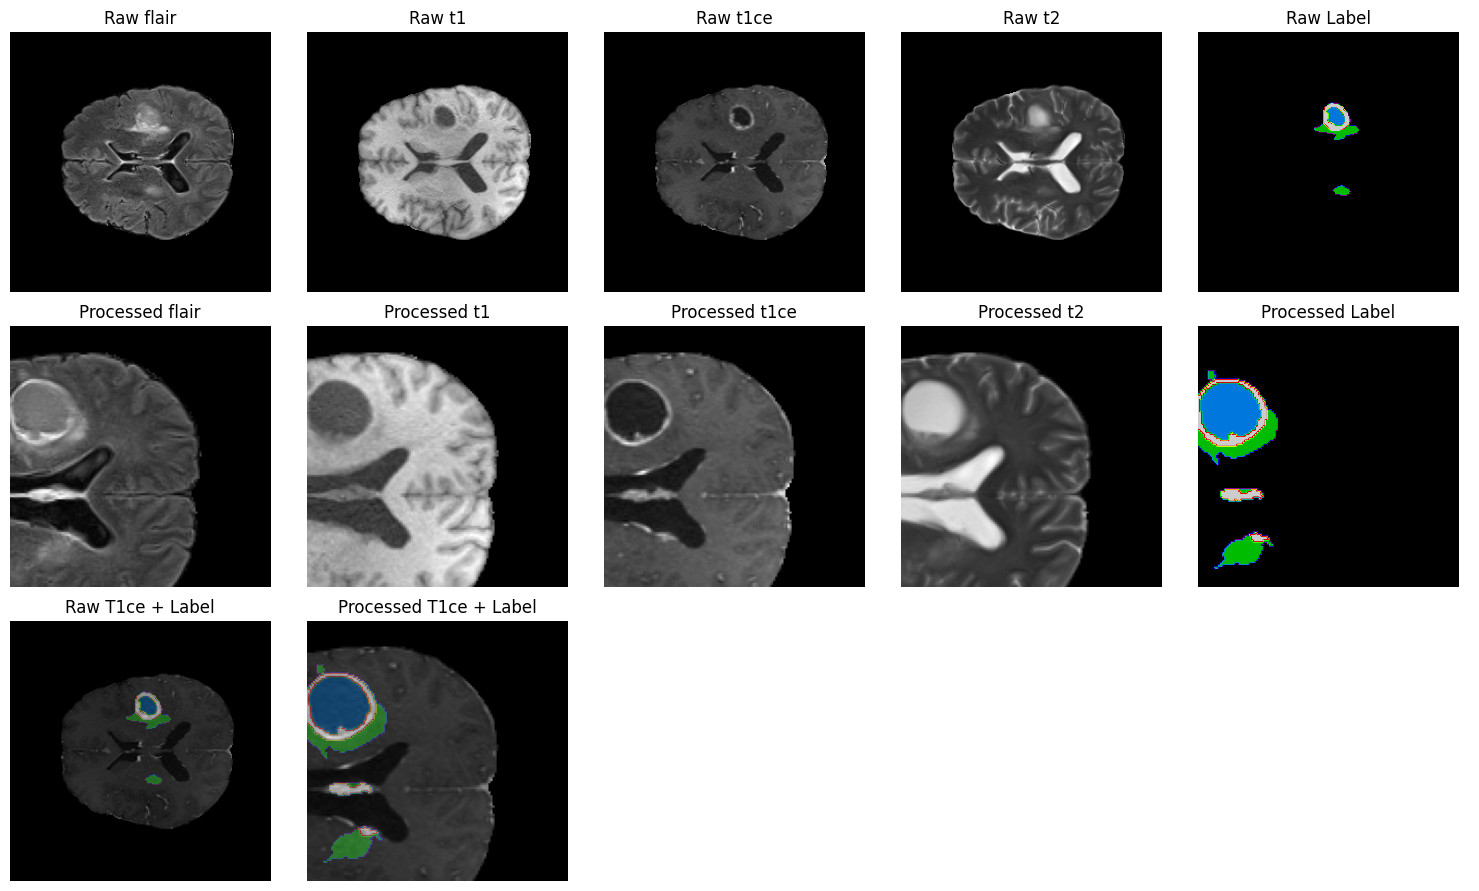

In [18]:
import random
import matplotlib.pyplot as plt

# Pick one random patient
sample_patient = random.choice(patient_dirs)
print(f"Random patient directory: {sample_patient}")

# Load raw images (before processing)
modalities = ['flair', 't1', 't1ce', 't2']
raw_images = []
for mod in modalities:
    file_path = os.path.join(sample_patient, f"{os.path.basename(sample_patient)}_{mod}.nii.gz")
    raw_img = nib.load(file_path).get_fdata(dtype=np.float32)
    raw_images.append(raw_img)

# Load raw label
label_path = os.path.join(sample_patient, f"{os.path.basename(sample_patient)}_seg.nii.gz")
raw_label = nib.load(label_path).get_fdata(dtype=np.float32).astype(np.uint8)

# Apply Dataset processing
dataset = BraTSDataset([sample_patient], patch_size=(128, 128, 128), num_samples_per_volume=8, augment=False)
processed_img, processed_lbl = dataset[0]  # first sample

print(f"Processed image shape: {processed_img.shape}")  
print(f"Processed label shape: {processed_lbl.shape}") 

# Pick a middle slice
slice_idx = raw_images[0].shape[2] // 2
processed_slice_idx = processed_img.shape[2] // 2

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# BEFORE: raw slices
for i, mod in enumerate(modalities):
    axes[0, i].imshow(raw_images[i][:, :, slice_idx], cmap="gray")
    axes[0, i].set_title(f"Raw {mod}")
    axes[0, i].axis("off")
axes[0, 4].imshow(raw_label[:, :, slice_idx], cmap="nipy_spectral")
axes[0, 4].set_title("Raw Label")
axes[0, 4].axis("off")

# AFTER: processed patch
for i, mod in enumerate(modalities):
    axes[1, i].imshow(processed_img[i, :, :, processed_slice_idx].numpy(), cmap="gray")
    axes[1, i].set_title(f"Processed {mod}")
    axes[1, i].axis("off")
axes[1, 4].imshow(processed_lbl[0, :, :, processed_slice_idx].numpy(), cmap="nipy_spectral")
axes[1, 4].set_title("Processed Label")
axes[1, 4].axis("off")

# OVERLAY: label on T1ce (raw vs processed)
raw_t1ce = raw_images[2][:, :, slice_idx]
processed_t1ce = processed_img[2, :, :, processed_slice_idx].numpy()
raw_lbl_slice = raw_label[:, :, slice_idx]
proc_lbl_slice = processed_lbl[0, :, :, processed_slice_idx].numpy()

# Raw overlay
axes[2, 0].imshow(raw_t1ce, cmap="gray")
axes[2, 0].imshow(raw_lbl_slice, cmap="nipy_spectral", alpha=0.4)
axes[2, 0].set_title("Raw T1ce + Label")
axes[2, 0].axis("off")

# Processed overlay
axes[2, 1].imshow(processed_t1ce, cmap="gray")
axes[2, 1].imshow(proc_lbl_slice, cmap="nipy_spectral", alpha=0.4)
axes[2, 1].set_title("Processed T1ce + Label")
axes[2, 1].axis("off")

# leave rest blank for spacing
for j in range(2, 5):
    axes[2, j].axis("off")

plt.tight_layout()
plt.show()


In [8]:
## Cell 6: Create Datasets and DataLoaders

# Split the list of patient directories into training (80%) and validation (20%) sets
train_files, val_files = train_test_split(patient_dirs, test_size=0.2, random_state=42)

# Create custom datasets for training and validation
# For training, we apply augmentation and extract more patches from each volume
train_ds = BraTSDataset(train_files, augment=True, num_samples_per_volume=8)

# For validation, no augmentation and fewer patches for faster evaluation
val_ds = BraTSDataset(val_files, augment=False, num_samples_per_volume=2)

# Create the DataLoaders
# A batch size of 2 is a good starting point for 128x128x128 patches on a standard Kaggle GPU
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")
print("DataLoaders are ready.")

Training samples: 8000, Validation samples: 502
DataLoaders are ready.


In [9]:
## Cell 7: Training Loop with Mixed Precision (AMP) + Multi-GPU (legacy autocast)

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import numpy as np
from tqdm import tqdm

def train_model_amp(model, train_loader, val_loader, device, 
                    max_epochs=5, lr=1e-4, save_path="/kaggle/working/best_model_amp.pth"):
    """
    Train a 3D U-Net model with mixed precision and multi-GPU support.
    """

    # Wrap model in DataParallel if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        print(f"⚡ Using {torch.cuda.device_count()} GPUs with DataParallel")
        model = nn.DataParallel(model)

    model = model.to(device)

    # Loss & Optimizer
    loss_function = DiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = amp.GradScaler()   # legacy-compatible

    best_metric = -1
    best_metric_epoch = -1

    for epoch in range(max_epochs):
        print("-" * 30)
        print(f"Epoch {epoch+1}/{max_epochs}")

        # --- Training ---
        model.train()
        epoch_loss = 0
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with amp.autocast():   # ✅ legacy-compatible autocast
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        print(f"Epoch {epoch+1} - Avg Training Loss: {epoch_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_dice_scores = []
        with torch.no_grad():
            for val_inputs, val_labels in tqdm(val_loader, desc="Validating"):
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                # Run eval in FP32 for stability
                val_outputs = model(val_inputs)

                preds = torch.argmax(val_outputs, dim=1, keepdim=True)
                val_labels_c = val_labels.clone()
                val_labels_c[val_labels_c == 4] = 3

                pred_one_hot = nn.functional.one_hot(
                    preds.squeeze(1), num_classes=4
                ).permute(0, 4, 1, 2, 3)
                label_one_hot = nn.functional.one_hot(
                    val_labels_c.squeeze(1), num_classes=4
                ).permute(0, 4, 1, 2, 3)

                intersection = torch.sum(pred_one_hot[:, 1:] * label_one_hot[:, 1:])
                union = torch.sum(pred_one_hot[:, 1:]) + torch.sum(label_one_hot[:, 1:])
                dice_score = (2. * intersection + 1e-5) / (union + 1e-5)
                val_dice_scores.append(dice_score.item())

        metric = np.mean(val_dice_scores)
        print(f"Validation Dice: {metric:.4f}")

        # Save best model (handle DataParallel properly)
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state_dict, save_path)
            print("✅ New best model saved!")

        print(f"Best Dice so far: {best_metric:.4f} (Epoch {best_metric_epoch})")

    print("\n🎉 Training complete!")
    print(f"🏆 Best validation Dice: {best_metric:.4f} at epoch {best_metric_epoch}")
    return model


In [10]:


# Initialize model (consider smaller channels if still OOM)
model = UNet3D(in_channels=4, out_classes=4).to(device)

# Train with AMP
trained_model = train_model_amp(
    model,
    train_loader,
    val_loader,
    device,
    max_epochs=5,
    lr=1e-4,
    save_path="/kaggle/working/best_baseline_model_amp.pth"
)


⚡ Using 2 GPUs with DataParallel


/tmp/ipykernel_36/7189496.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()   # legacy-compatible


------------------------------
Epoch 1/5


Training:   0%|          | 0/4000 [00:00<?, ?it/s]/tmp/ipykernel_36/7189496.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():   # ✅ legacy-compatible autocast
Training: 100%|██████████| 4000/4000 [1:19:18<00:00,  1.19s/it]


Epoch 1 - Avg Training Loss: 0.3489


Validating: 100%|██████████| 251/251 [05:45<00:00,  1.37s/it]


Validation Dice: 0.7599
✅ New best model saved!
Best Dice so far: 0.7599 (Epoch 1)
------------------------------
Epoch 2/5


Training: 100%|██████████| 4000/4000 [1:19:06<00:00,  1.19s/it]


Epoch 2 - Avg Training Loss: 0.2294


Validating: 100%|██████████| 251/251 [05:43<00:00,  1.37s/it]


Validation Dice: 0.7940
✅ New best model saved!
Best Dice so far: 0.7940 (Epoch 2)
------------------------------
Epoch 3/5


Training: 100%|██████████| 4000/4000 [1:19:07<00:00,  1.19s/it]


Epoch 3 - Avg Training Loss: 0.2150


Validating: 100%|██████████| 251/251 [05:45<00:00,  1.38s/it]


Validation Dice: 0.7430
Best Dice so far: 0.7940 (Epoch 2)
------------------------------
Epoch 4/5


Training: 100%|██████████| 4000/4000 [1:19:29<00:00,  1.19s/it]


Epoch 4 - Avg Training Loss: 0.2099


Validating: 100%|██████████| 251/251 [05:42<00:00,  1.36s/it]


Validation Dice: 0.8066
✅ New best model saved!
Best Dice so far: 0.8066 (Epoch 4)
------------------------------
Epoch 5/5


Training: 100%|██████████| 4000/4000 [1:18:40<00:00,  1.18s/it]


Epoch 5 - Avg Training Loss: 0.2044


Validating: 100%|██████████| 251/251 [05:41<00:00,  1.36s/it]


Validation Dice: 0.8151
✅ New best model saved!
Best Dice so far: 0.8151 (Epoch 5)

🎉 Training complete!
🏆 Best validation Dice: 0.8151 at epoch 5


In [17]:
## Cell 8: Final Evaluation

# Load the best model state from the file
save_path = "/kaggle/working/best_baseline_model_amp.pth"
model.load_state_dict(torch.load(save_path))
model.eval()

total_dice_score = 0
num_samples = 0

with torch.no_grad():
    for val_inputs, val_labels in tqdm(val_loader, desc="Final Evaluation"):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)

        # predictions (B, D, H, W)
        preds = torch.argmax(val_outputs, dim=1)
        val_labels_c = val_labels.clone().squeeze(1)
        val_labels_c[val_labels_c == 4] = 3

        # one-hot encode
        pred_one_hot = nn.functional.one_hot(preds, num_classes=4).permute(0, 4, 1, 2, 3)
        label_one_hot = nn.functional.one_hot(val_labels_c, num_classes=4).permute(0, 4, 1, 2, 3)

        # dice
        intersection = torch.sum(pred_one_hot[:, 1:] * label_one_hot[:, 1:])
        union = torch.sum(pred_one_hot[:, 1:]) + torch.sum(label_one_hot[:, 1:])
        dice_score = (2. * intersection + 1e-5) / (union + 1e-5)

        total_dice_score += dice_score.item()
        num_samples += 1

mean_dice = total_dice_score / num_samples
print(f"\n Final Mean Dice Score on Validation Set: {mean_dice:.4f}")


Final Evaluation: 100%|██████████| 251/251 [10:45<00:00,  2.57s/it]


✅ Final Mean Dice Score on Validation Set: 0.8179
